# Lecture 50: Semantic Segmentation

## Dataset used: [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/)

In [1]:

import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize, imread, imshow
import scipy
import cv2
import time
import os

### Load Data

In [2]:
trainPath = 'Camvid_train_images/train/'
testPath = 'Camvid_train_images/test/'

In [3]:
# trainPath = 'drive11/train/'
# testPath = 'drive11/test/'

Text(0.5,1,'Ground Truth')

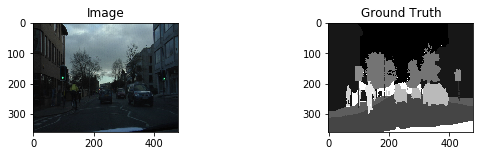

In [3]:
# Displaying sample image, groundtruth and mask from the dataset
# sampleImg = np.array(Image.open(trainPath+'images/1 (1).png'))
# sampleGT = np.array(Image.open(trainPath+'1st_manual/1 (1).png'))
sampleImg = np.array(Image.open(trainPath+'rgb/train_1.png'))
sampleGT = np.array(Image.open(trainPath+'mask/train_1.png'))
# sampleMask = np.array(Image.open(trainPath+'mask/21_training_mask.gif'))
plt.figure(figsize=(15,2))
plt.subplot(131)
plt.imshow(sampleImg)
plt.title('Image')
plt.subplot(132)
plt.imshow(sampleGT,cmap='gray')
plt.title('Ground Truth')
# plt.subplot(133)
# plt.imshow(sampleMask,cmap='gray')
# plt.title('Mask')

In [4]:
def get_predictions(output_batch):
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs,h,w)
    return indices

In [5]:
# DRIVE dataset has 20 images for training and 20 for testing
TrainImages = torch.FloatTensor(50,3, 360, 480) # 20 images x 30 patches
TrainLabels = torch.FloatTensor(50,360,480)
TestImages = torch.FloatTensor(20,3,360,480)
TestLabels = torch.FloatTensor(20,360,480)

# Obtain list containing name of all files in the directoy
trainImgList = os.listdir(trainPath+'rgb')
testImgList = os.listdir(testPath+'mask')

# Preparing train data tensors
img_no = 0
for file in trainImgList:
#     imgNum = file.split('_')[0] # Image number from the filename
    im = Image.open(trainPath+'rgb/'+ file)
    
    seg = Image.open(trainPath+'mask/'+file)
#     mask = Image.open(trainPath+'mask/'+str(imgNum)+'_training_mask.gif')
    im = np.array(im)/255
#     print(im.shape)
    seg = np.array(seg)
#     TrainImages[img_no] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
#     TrainLabels[img_no] = torch.from_numpy(seg).transpose(0,1).unsqueeze(0)
    TrainImages[img_no] = torch.from_numpy(im).transpose(1,2).transpose(0,1)
    TrainLabels[img_no] = torch.from_numpy(seg)
    img_no += 1


# Preparing test data tensors
img_no = 0
for file in testImgList:
#     imgNum = file.split('_')[0] # Image number from the filename
    im = Image.open(testPath+'rgb/'+ file)
    seg = Image.open(testPath+'mask/'+ file)
#     mask = Image.open(testPath+'mask/'+str(imgNum)+'_test_mask.gif')
    # Resizing the images to 224x224
#     im = np.array(im.resize((224,224)))/255
    im = np.array(im)/255
#     seg = np.array(seg.resize((224,224)))/255
    seg = np.array(seg)
#     mask = (np.array(mask.resize((224,224)))-seg)/255
#     idx = np.where(mask==1)
#     # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
#     seg[idx] = 2
#     TestImages[img_no] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
#     TestLabels[img_no] = torch.from_numpy(seg).transpose(0,1).unsqueeze(0)
    TestImages[img_no] = torch.from_numpy(im).transpose(1,2).transpose(0,1)
    TestLabels[img_no] = torch.from_numpy(seg)
    img_no += 1

In [6]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([1842, 3, 360, 480])
torch.Size([1842, 360, 480])
torch.Size([87, 3, 360, 480])
torch.Size([87, 360, 480])


In [7]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 7
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=False,num_workers=4, pin_memory=True)

In [8]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


## Defining network architecture

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()        
        
        # Encoder
        self.conv1c = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Decoder
        self.mup1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1d = nn.Conv2d(64, 12, kernel_size=3, stride=1, padding=1)
        
        

    def forward(self, x):
        x = self.relu1(self.conv1c(x))
        x, idx1 = self.mp1(x)    
        x = self.mup1(x, idx1)
        x = self.conv1d(x)
        x = F.log_softmax(x)
        return x

In [9]:
# import torch
# import torch.nn.functional as F
from torch import nn

from misc import initialize_weights1


class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        initialize_weights1(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        x = F.upsample(final, x.size()[2:], mode='bilinear')
        x = F.log_softmax(x)
#         m = torch.nn.Softmax()
#         x = m(x)
        #x = x.view(-1,360,480)
        
        return x

In [11]:
# net = SegNet()
net = UNet(12)
input=torch.randn([1,3,360,480])
output=net(input)
print(output.shape)
x=get_predictions(output)
print(x.shape)

/media/hulk-css/New Volume/Deep_Learning/semantic_seg_dataset_creation/misc.py:20: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


torch.Size([1, 12, 360, 480])
torch.Size([1, 360, 480])


/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/hulk-css/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Initializing network

In [10]:
# net = SegNet()
net = UNet(12)
if use_gpu:
    net = net.cuda()

/media/hulk-css/New Volume/Deep_Learning/semantic_seg_dataset_creation/misc.py:20: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


## Define loss function and optimizer

In [11]:
criterion = nn.NLLLoss2d() # 2D Negative Log-Likelihood
criterion.cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:216: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


## Train the network

/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/hulk-css/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


At Iteration: 1 /135  ;  Training Loss: 0.130868; Time consumed: 1m 9s 
At Iteration: 1 /135  ;  Testing Loss: 0.103914 ; Time consumed: 1m 9s 
At Iteration: 2 /135  ;  Training Loss: 0.086564; Time consumed: 1m 9s 
At Iteration: 2 /135  ;  Testing Loss: 0.084635 ; Time consumed: 1m 9s 
At Iteration: 3 /135  ;  Training Loss: 0.076659; Time consumed: 1m 10s 
At Iteration: 3 /135  ;  Testing Loss: 0.073781 ; Time consumed: 1m 10s 
At Iteration: 4 /135  ;  Training Loss: 0.069330; Time consumed: 1m 10s 
At Iteration: 4 /135  ;  Testing Loss: 0.064164 ; Time consumed: 1m 10s 
At Iteration: 5 /135  ;  Training Loss: 0.063590; Time consumed: 1m 10s 
At Iteration: 5 /135  ;  Testing Loss: 0.065407 ; Time consumed: 1m 10s 
At Iteration: 6 /135  ;  Training Loss: 0.059739; Time consumed: 1m 10s 
At Iteration: 6 /135  ;  Testing Loss: 0.059512 ; Time consumed: 1m 10s 
At Iteration: 7 /135  ;  Training Loss: 0.055193; Time consumed: 1m 10s 
At Iteration: 7 /135  ;  Testing Loss: 0.059251 ; Time 

At Iteration: 57 /135  ;  Training Loss: 0.021562; Time consumed: 1m 10s 
At Iteration: 57 /135  ;  Testing Loss: 0.042684 ; Time consumed: 1m 10s 
At Iteration: 58 /135  ;  Training Loss: 0.017864; Time consumed: 1m 10s 
At Iteration: 58 /135  ;  Testing Loss: 0.044727 ; Time consumed: 1m 10s 
At Iteration: 59 /135  ;  Training Loss: 0.018662; Time consumed: 1m 10s 
At Iteration: 59 /135  ;  Testing Loss: 0.043142 ; Time consumed: 1m 10s 
At Iteration: 60 /135  ;  Training Loss: 0.016477; Time consumed: 1m 10s 
At Iteration: 60 /135  ;  Testing Loss: 0.044133 ; Time consumed: 1m 10s 
At Iteration: 61 /135  ;  Training Loss: 0.016009; Time consumed: 1m 10s 
At Iteration: 61 /135  ;  Testing Loss: 0.045124 ; Time consumed: 1m 10s 
At Iteration: 62 /135  ;  Training Loss: 0.015977; Time consumed: 1m 10s 
At Iteration: 62 /135  ;  Testing Loss: 0.045128 ; Time consumed: 1m 10s 
At Iteration: 63 /135  ;  Training Loss: 0.015608; Time consumed: 1m 10s 
At Iteration: 63 /135  ;  Testing Loss

At Iteration: 113 /135  ;  Training Loss: 0.009972; Time consumed: 1m 10s 
At Iteration: 113 /135  ;  Testing Loss: 0.066736 ; Time consumed: 1m 10s 
At Iteration: 114 /135  ;  Training Loss: 0.014745; Time consumed: 1m 10s 
At Iteration: 114 /135  ;  Testing Loss: 0.055181 ; Time consumed: 1m 10s 
At Iteration: 115 /135  ;  Training Loss: 0.010961; Time consumed: 1m 10s 
At Iteration: 115 /135  ;  Testing Loss: 0.056040 ; Time consumed: 1m 10s 
At Iteration: 116 /135  ;  Training Loss: 0.009775; Time consumed: 1m 10s 
At Iteration: 116 /135  ;  Testing Loss: 0.058529 ; Time consumed: 1m 10s 
At Iteration: 117 /135  ;  Training Loss: 0.009619; Time consumed: 1m 10s 
At Iteration: 117 /135  ;  Testing Loss: 0.060362 ; Time consumed: 1m 10s 
At Iteration: 118 /135  ;  Training Loss: 0.009652; Time consumed: 1m 12s 
At Iteration: 118 /135  ;  Testing Loss: 0.059196 ; Time consumed: 1m 12s 
At Iteration: 119 /135  ;  Training Loss: 0.010180; Time consumed: 1m 11s 
At Iteration: 119 /135  ;

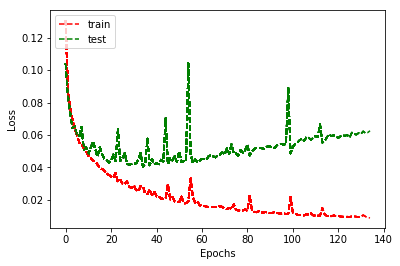

In [12]:
iterations = 135
trainLoss = []
testLoss = []
start = time.time()
best_test_loss = np.inf
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0   
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels.long())      
 
        
        # Feed-forward input data through the network
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(outputs, labels)      
        # Initialize gradients to zero
        optimizer.zero_grad()                  
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.item()          
    avgTrainLoss = runningLoss/TrainImages.size()[0]   
    trainLoss.append(avgTrainLoss)
  
    
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing
    test_runningLoss = 0    
    for data in testLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels.long())         
        outputs = net(inputs)       
         # Compute loss/error
        loss = criterion(outputs, labels)      
        # Accumulate loss per batch
        test_runningLoss += loss.item() 
        
    avgTestLoss = test_runningLoss/TestImages.size()[0]    
    testLoss.append(avgTestLoss)
        
    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
    plt.plot(range(epoch+1),testLoss,'g--',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
      
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
    print('At Iteration: {:.0f} /{:.0f}  ;  Testing Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTestLoss,epochEnd//60,epochEnd%60))
    
    if best_test_loss > avgTestLoss:
        best_test_loss = avgTestLoss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')
    torch.save(net.state_dict(),'bestweight.pth')
    
    
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))
torch.save(net.state_dict(),"UNET_seg_Camvid_epochs_%d.pth"%(epoch+1))

In [13]:
net = net.cuda()
net.load_state_dict(torch.load("UNET_segmentation_epochs_50.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

/home/hulk-css/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/hulk-css/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=

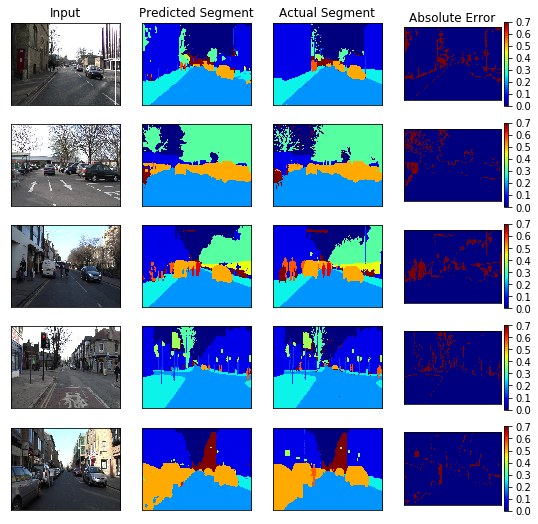

In [45]:
import cv2
net.eval()
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)
ind = 0
flag = 0

#imageinds = [345,255,468,630,170]
#imageinds = [0,1,2,3,4]
ind11 = np.random.permutation(TestImages.size()[0])
imageinds = [ind11[0],ind11[1],ind11[2],ind11[3],ind11[4]]

#imageinds = [463,464,465,466,467]
#imageinds = [155,156,157,158,159]

for i in range(1,21,4):
    nind = imageinds[ind]
    
    img1 = np.zeros((360,480,3))
    temp = TestImages[nind]
    #print(finxtest1[5].shape)

    img1[:,:,0] = temp[0,:,:]
    img1[:,:,1] = temp[1,:,:]
    img1[:,:,2] = temp[2,:,:]
    img1 = imresize(img1,(360,480,3))
    
    a=fig.add_subplot(5,4,i)
    imgplot = plt.imshow(img1)
    if flag == 0:
        a.set_title('Input')
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    a=fig.add_subplot(5,4,i+1)
    ##################################################
    testPT = TestImages[nind]
    testPT = testPT.view(1,3,360,480)
    test_pred = net.forward(Variable(testPT, volatile=True).cuda())
    test_pred=get_predictions(test_pred)
    testx11 = test_pred.cpu()
    testx = testx11.detach().numpy()
    testx = np.reshape(testx,(1,360,480))
    testx = testx.transpose(1,2,0)
    testx = cv2.resize(testx,(480,360))
    imgplot = plt.imshow(testx)
    imgplot.set_cmap('jet')
    #print("hi inside")
    if flag == 0:
        a.set_title('Predicted Segment')
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    ##################################################
    a=fig.add_subplot(5,4,i+2)
    tar = TestLabels[nind]
    tar_x = tar.numpy()
    tar_x = np.reshape(tar_x,(1,360,480))
    tar_x = tar_x.transpose(1,2,0)
    tar_x = cv2.resize(tar_x,(480,360))
    imgplot = plt.imshow(tar_x)
    imgplot.set_cmap('jet')
    if flag == 0:
        a.set_title('Actual Segment')
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    ##################################################
    a=fig.add_subplot(5,4,i+3)
#     ytest = ytestT[nind].numpy()
    error1 = np.abs(testx-tar_x)
    #print "max is --->", error1.max()
    #print "min is --->", error1.min()
    imgplot = plt.imshow(error1)
    if flag == 0:
        a.set_title('Absolute Error')
    #imgplot.set_rotation(0)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    #imgplot.set_cmap('hot')
    imgplot.set_cmap('jet')
    plt.colorbar(fraction=0.080, pad=0.03)
    #plt.colorbar(fraction=0.080, pad=0.03,ticks=[0.0,0.2,0.4,0.6])
    #plt.clim(0,1)
    plt.clim(vmin=0, vmax=0.7)
    ##################################################
    ind += 1
    flag = 1

/home/hulk-css/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hulk-css/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/hulk-css/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=

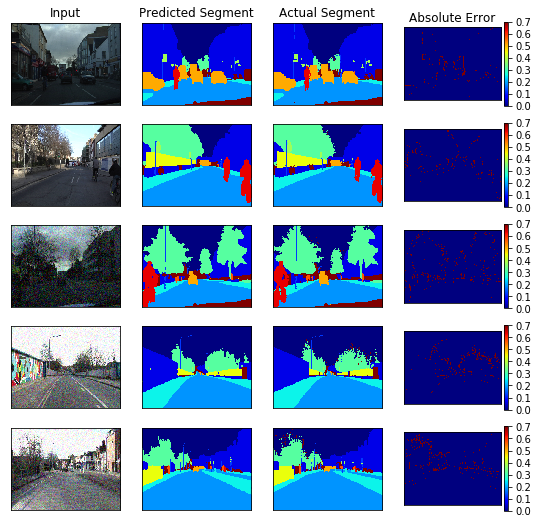

In [42]:
import cv2
net.eval()
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)
ind = 0
flag = 0

#imageinds = [345,255,468,630,170]
#imageinds = [0,1,2,3,4]
ind11 = np.random.permutation(TrainImages.size()[0])
imageinds = [ind11[0],ind11[1],ind11[2],ind11[3],ind11[4]]

#imageinds = [463,464,465,466,467]
#imageinds = [155,156,157,158,159]

for i in range(1,21,4):
    nind = imageinds[ind]
    
    img1 = np.zeros((360,480,3))
    temp = TrainImages[nind]
    #print(finxtest1[5].shape)

    img1[:,:,0] = temp[0,:,:]
    img1[:,:,1] = temp[1,:,:]
    img1[:,:,2] = temp[2,:,:]
    img1 = imresize(img1,(360,480,3))
    
    a=fig.add_subplot(5,4,i)
    imgplot = plt.imshow(img1)
    if flag == 0:
        a.set_title('Input')
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    a=fig.add_subplot(5,4,i+1)
    ##################################################
    testPT = TrainImages[nind]
    testPT = testPT.view(1,3,360,480)
    test_pred = net.forward(Variable(testPT, volatile=True).cuda())
    test_pred=get_predictions(test_pred)
    testx11 = test_pred.cpu()
    testx = testx11.detach().numpy()
    testx = np.reshape(testx,(1,360,480))
    testx = testx.transpose(1,2,0)
    testx = cv2.resize(testx,(480,360))
    imgplot = plt.imshow(testx)
    imgplot.set_cmap('jet')
    #print("hi inside")
    if flag == 0:
        a.set_title('Predicted Segment')
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    ##################################################
    a=fig.add_subplot(5,4,i+2)
    tar = TrainLabels[nind]
    tar_x = tar.numpy()
    tar_x = np.reshape(tar_x,(1,360,480))
    tar_x = tar_x.transpose(1,2,0)
    tar_x = cv2.resize(tar_x,(480,360))
    imgplot = plt.imshow(tar_x)
    imgplot.set_cmap('jet')
    if flag == 0:
        a.set_title('Actual Segment')
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    ##################################################
    a=fig.add_subplot(5,4,i+3)
#     ytest = ytestT[nind].numpy()
    error1 = np.abs(testx-tar_x)
    #print "max is --->", error1.max()
    #print "min is --->", error1.min()
    imgplot = plt.imshow(error1)
    if flag == 0:
        a.set_title('Absolute Error')
    #imgplot.set_rotation(0)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    #imgplot.set_cmap('hot')
    imgplot.set_cmap('jet')
    plt.colorbar(fraction=0.080, pad=0.03)
    #plt.colorbar(fraction=0.080, pad=0.03,ticks=[0.0,0.2,0.4,0.6])
    #plt.clim(0,1)
    plt.clim(vmin=0, vmax=0.7)
    ##################################################
    ind += 1
    flag = 1

In [ ]:
# # Visualizing segmentation on one of the test images
# randIdx = np.random.randint(20)
# testImg = TestImages[randIdx]
# testLab = TestLabels[randIdx].numpy()

# # Feed-forward 
# # segImg = net(Variable(testImg).unsqueeze(0).cuda())
# segImg = net(Variable(testImg).unsqueeze(0))
# # Applying softmax to get class probabilities
# segImg_np = F.softmax(segImg).data.cpu().squeeze(0).numpy()

# # Displaying segmented output and ground truth
# plt.figure(figsize=(15,15))
# plt.subplot(231)
# plt.imshow(segImg_np[0,:,:],cmap='gray')
# plt.title('Channel 1')
# plt.subplot(232)
# plt.imshow(segImg_np[1,:,:],cmap='gray')
# plt.title('Channel 2')
# plt.subplot(233)
# plt.imshow(segImg_np[2,:,:],cmap='gray')
# plt.title('Channel 3')


# bg = testLab==0
# vessel = testLab==1
# tissue = testLab==2
# plt.subplot(234)
# plt.imshow(bg,cmap='gray')
# plt.title('Background')
# plt.subplot(235)
# plt.imshow(vessel,cmap='gray')
# plt.title('Vessel')
# plt.subplot(236)
# plt.imshow(tissue,cmap='gray')
# plt.title('Tissue')